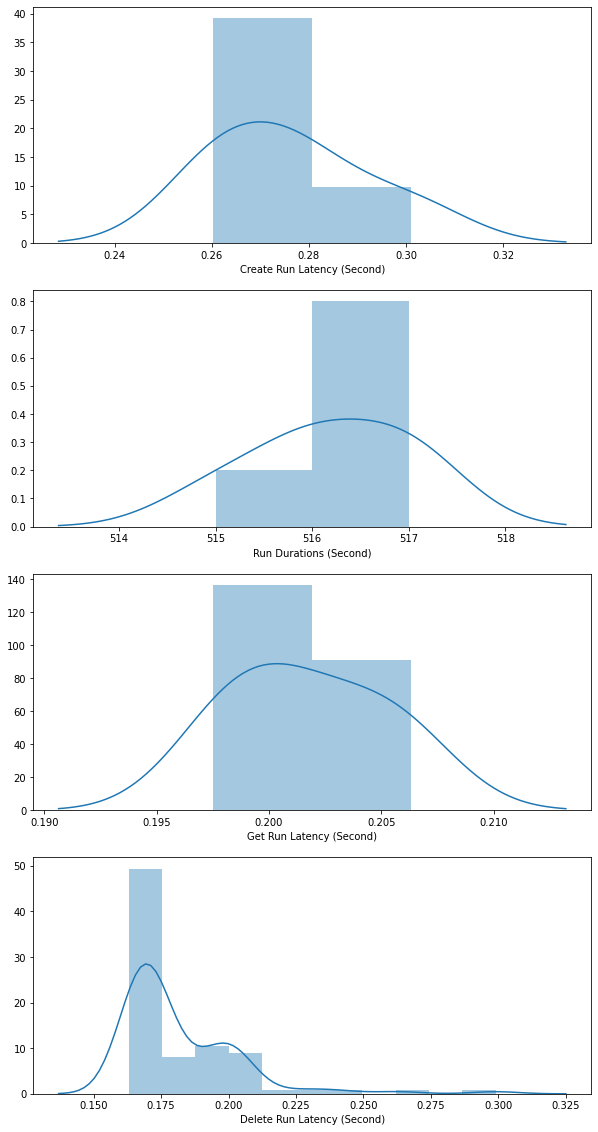

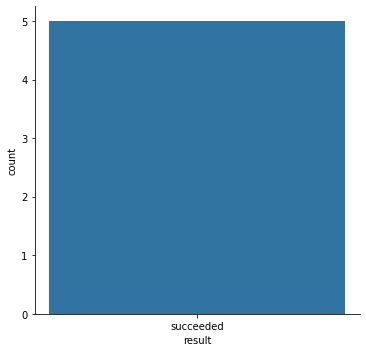

In [11]:
# This benchmark measures the performance of run related operations in Kubeflow pipelines, including run durations and latencies of creating/getting/deleting runs.

import random
import kfp
import kfp_server_api
import os
import string
import time
from google.cloud import storage
from kfp.components import create_component_from_func
from datetime import datetime, timezone, timedelta

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# CHANGE necessary paramters here
# host is your KFP endpoint
host = 'http://127.0.0.1:3001'
# Use the pipeline you prefer
pipeline_file_url = 'https://storage.googleapis.com/jingzhangjz-project-pipelines/benchmarks/taxi_2.yaml'
# number of runs you want to create
num_runs = 5
# Periodically check whether the runs have been finished.
run_status_polling_interval_sec = 10


def random_suffix() -> string:
    return ''.join(random.choices(string.ascii_lowercase + string.digits, k=10))

def run_finished(run_status: string) -> bool:
    return run_status in {'Succeeded', 'Failed', 'Error', 'Skipped', 'Terminated'}

def run_succeeded(run_status: string) -> bool:
    return run_status in {'Succeeded'}


if __name__ == '__main__':
    client = kfp.Client(host)
    
    # Create a pipeline and we'll use its default version to create runs.
    api_url = kfp_server_api.models.ApiUrl(pipeline_file_url)
    api_pipeline = kfp_server_api.models.ApiPipeline(
        name='pipeline-' + random_suffix(),
        url=api_url)
    pipeline = client.pipelines.create_pipeline(body=api_pipeline)
    default_version_id = pipeline.default_version.id

    # Create an experiment.
    experiment_name = 'experiment-' + random_suffix()
    experiment = client.experiments.create_experiment(body={'name' : experiment_name})
    experiment_id = experiment.id
    
    # Measure create run latency. Note this time is the roundrip latency of CreateRun method. The actual run is 
    # not finished when client side gets the CreateRun response. Run duration will be measured below when run is 
    # actually finished.
    created_runs = []
    create_run_latencies = []
    for i in range(num_runs):
        resource_references = []
        key = kfp_server_api.models.ApiResourceKey(id=experiment_id, type=kfp_server_api.models.ApiResourceType.EXPERIMENT)
        reference = kfp_server_api.models.ApiResourceReference(key=key, relationship=kfp_server_api.models.ApiRelationship.OWNER)
        resource_references.append(reference)
        key = kfp_server_api.models.ApiResourceKey(id=default_version_id, type=kfp_server_api.models.ApiResourceType.PIPELINE_VERSION)
        reference = kfp_server_api.models.ApiResourceReference(key=key, relationship=kfp_server_api.models.ApiRelationship.CREATOR)
        resource_references.append(reference)
        # If the pipeline you choose needs to specify parameters to create a run, specify it here.
        parameters = []
        parameter = kfp_server_api.ApiParameter(name='pipeline-root', value='gs://jingzhangjz-project-outputs/tfx_taxi_simple/{{workflow.uid}}')
        parameters.append(parameter)
        parameter = kfp_server_api.ApiParameter(name='data-root', value='gs://ml-pipeline-playground/tfx_taxi_simple/data')
        parameters.append(parameter)
        parameter = kfp_server_api.ApiParameter(name='module-file', value='gs://ml-pipeline-playground/tfx_taxi_simple/modules/taxi_utils.py')
        parameters.append(parameter)        
        pipeline_spec = kfp_server_api.ApiPipelineSpec(parameters=parameters)

        start = time.perf_counter()
        run_name = 'run-' + random_suffix()
        run = client.runs.create_run(body={'name':run_name, 'resource_references': resource_references, 'pipeline_spec': pipeline_spec})  
        dur = time.perf_counter() - start
        create_run_latencies.append(dur)   
        created_runs.append(run.run.id)
               
    # Wait for the runs to finish. 
    # TODO(jingzhang36): We can add a timeout for this polling. For now we rely on the timeout of runs in KFP. 
    while True:
        all_finished = True
        for i in created_runs:
            run = client.runs.get_run(i)  
            if not run_finished(run.run.status):
                all_finished = False
                break
        if all_finished:     
            break
        else:
            time.sleep(run_status_polling_interval_sec)

    # When all runs are finished, measure run durations and get run latencies.
    get_run_latencies = []
    succeeded_run_durations = []
    run_results = []
    for i in created_runs:
        start = time.perf_counter()
        run = client.runs.get_run(i)  
        dur = time.perf_counter() - start
        get_run_latencies.append(dur) 
        if run_succeeded(run.run.status):
            run_results.append('succeeded')
            succeeded_run_durations.append((run.run.finished_at - run.run.created_at).total_seconds())
        else:
            run_results.append('not_succeeded')

    # Measure delete run latency.
    delete_run_latencies = []
    for i in created_runs:
        start = time.perf_counter()
        run = client.runs.delete_run(i)  
        dur = time.perf_counter() - start
        delete_run_latencies.append(dur)   
    
    # Cleanup
    client.pipelines.delete_pipeline(pipeline.id)
    client.experiments.delete_experiment(experiment.id)
         
    # Plots
    fig, axs = plt.subplots(nrows=4, figsize=(10,20))
    
    label_create_run_latencies = pd.Series(create_run_latencies, name='Create Run Latency (Second)')
    sns.distplot(a=label_create_run_latencies,  ax=axs[0])
    
    label_run_durations = pd.Series(succeeded_run_durations, name='Run Durations (Second)')
    sns.distplot(a=label_run_durations,  ax=axs[1])    

    label_get_run_latencies = pd.Series(get_run_latencies, name='Get Run Latency (Second)')
    sns.distplot(a=label_get_run_latencies,  ax=axs[2])    
    
    label_delete_run_latencies = pd.Series(delete_run_latencies, name='Delete Run Latency (Second)')
    sns.distplot(a=label_delete_run_latencies,  ax=axs[3])
    
    loaded_run_results = pd.DataFrame(np.array(run_results), columns=['result'])
    sns.catplot(x='result', kind="count", data=loaded_run_results)
    